In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb


#Importing Data

In [3]:
# Set file paths (Make sure you place your files correctly in your Google Drive)
crop_path = '/content/drive/MyDrive/Colab Notebooks/crop_fertilizer_dataset/crop_recommendation.csv'


In [4]:
# Load datasets
crop_df = pd.read_csv(crop_path)


In [5]:
print("\nCrop Recommendation Dataset:")
crop_df.head()


Crop Recommendation Dataset:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
crop_df.shape


(2200, 8)

In [7]:
crop_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [8]:
# Check the missing values in the dataset
crop_df.isnull().sum()


,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


In [9]:
# Check the duplicated values in the dataset
crop_df.duplicated().sum()

np.int64(0)

In [10]:
# Check the basic statistics of the dataset
crop_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


#Exploring Data

In [11]:
# Check the target distribution
crop_df['label'].value_counts()

,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


In [12]:
features = crop_df.columns.to_list()
features.remove('label')
print(features)

['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


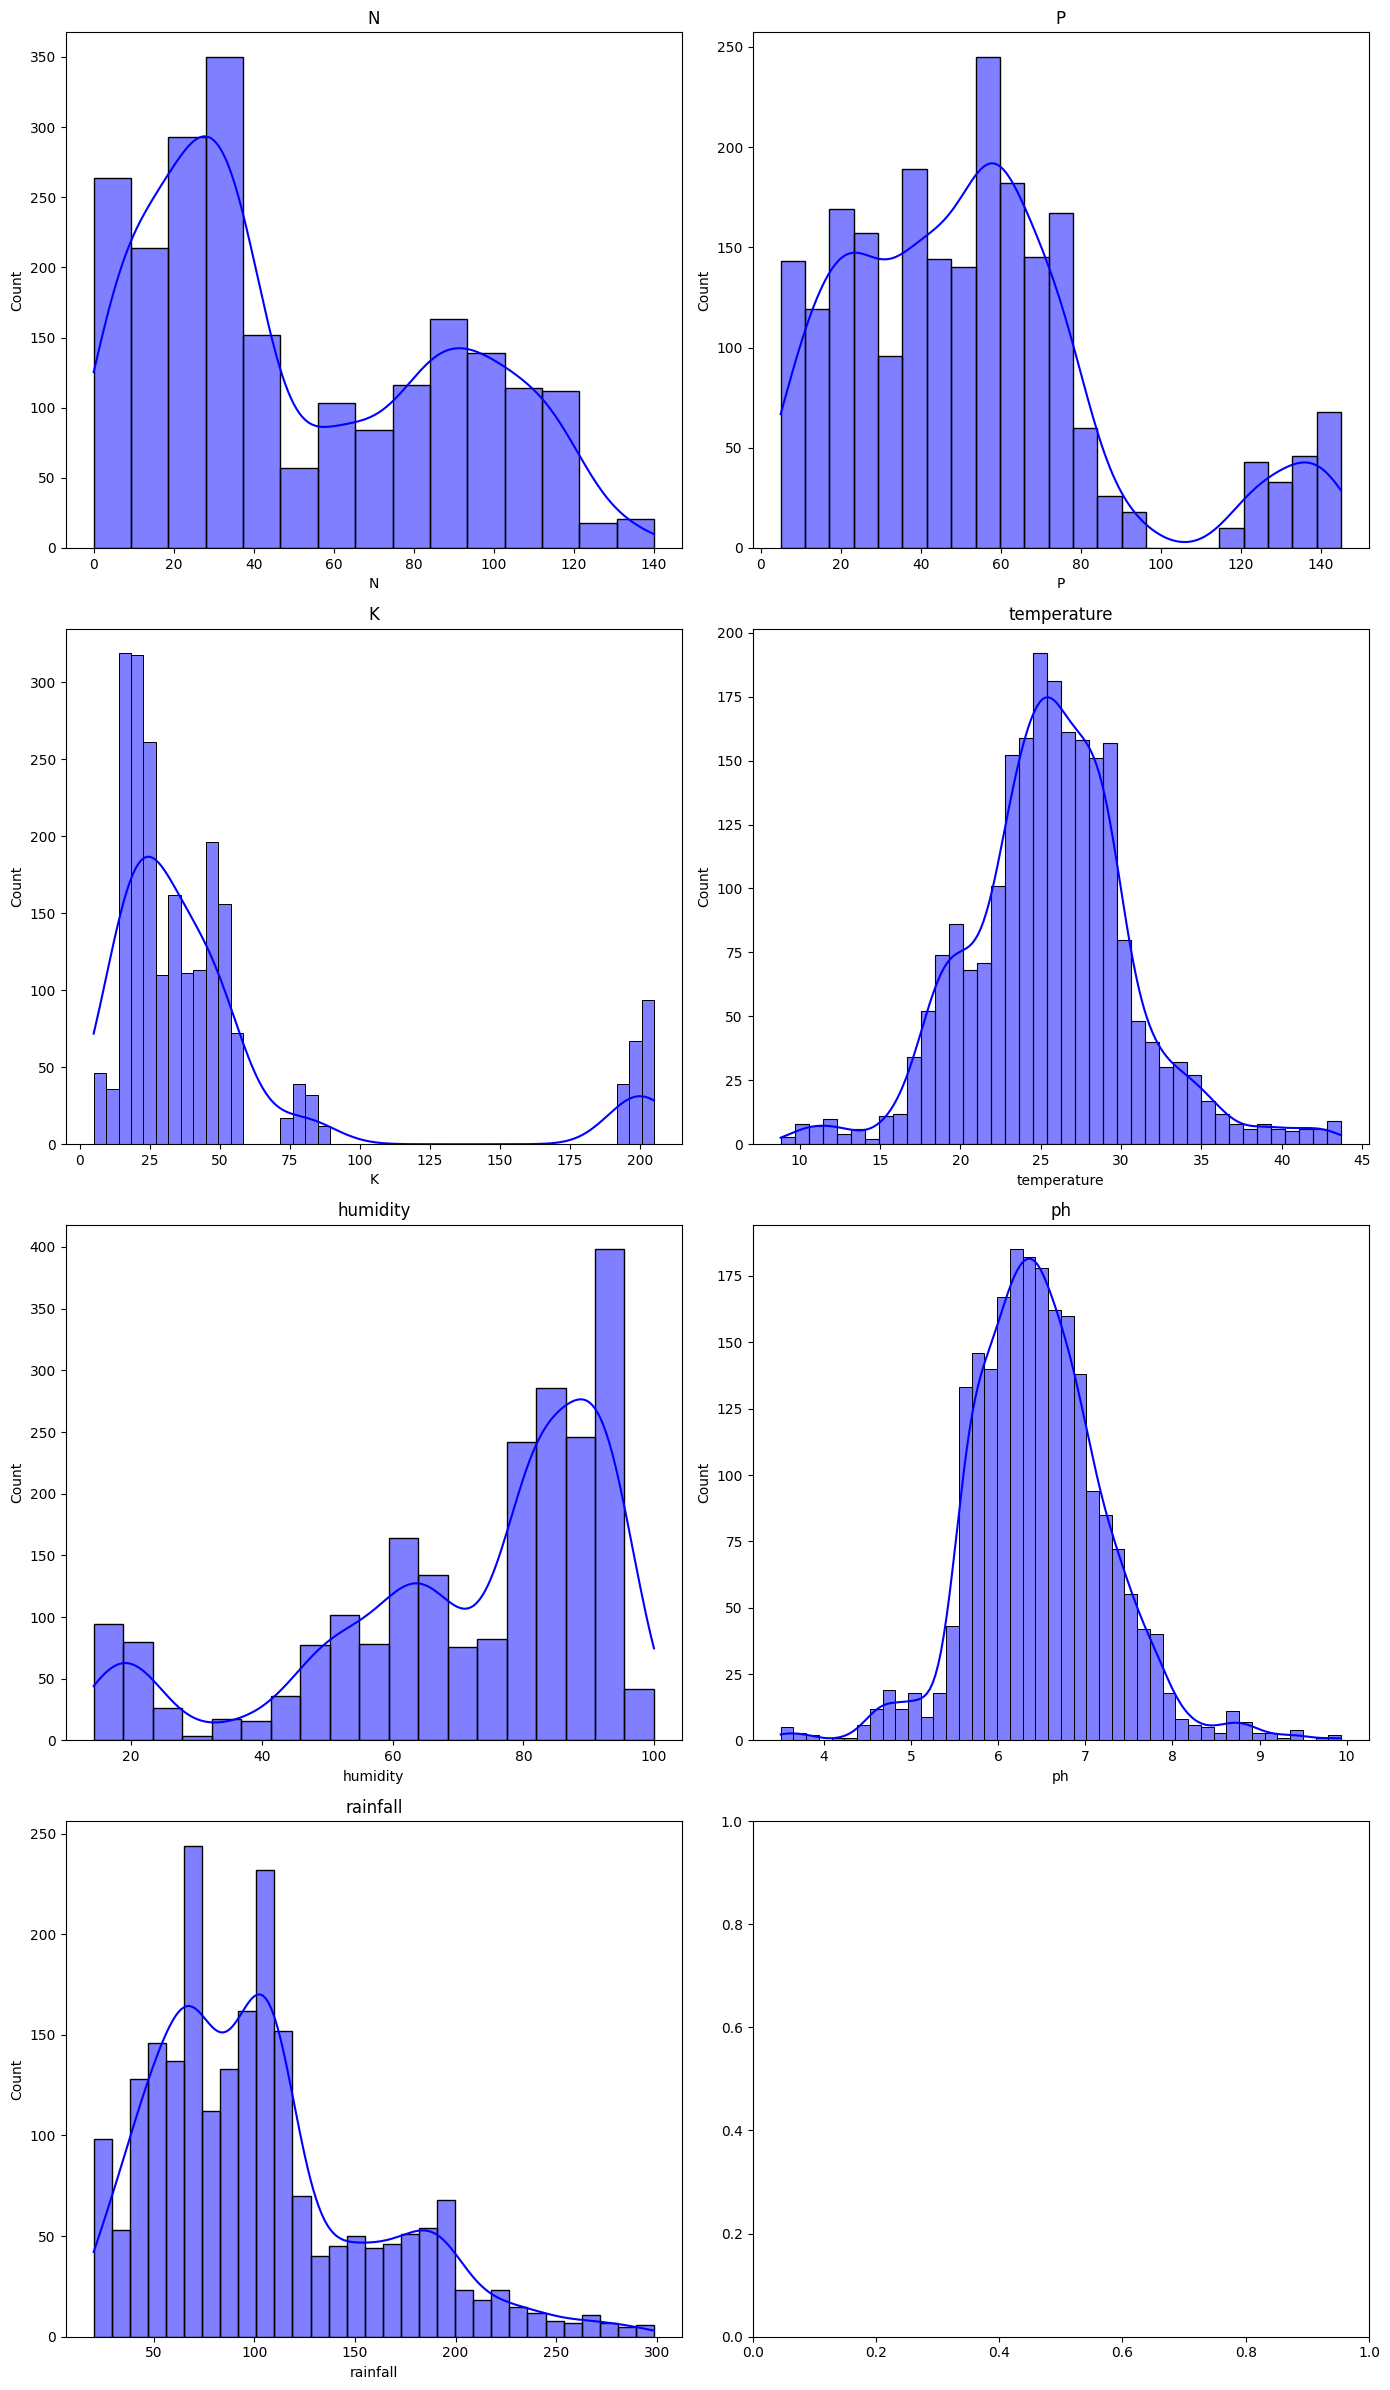

In [13]:
# visualize the distribution of each feature
fig, ax = plt.subplots(4, 2, figsize=(14, 24))
for i, subplot in zip(features, ax.flatten()):
    sns.histplot(crop_df[i], ax=subplot, kde=True, color='blue')
    subplot.set_title(i)
plt.tight_layout()
plt.show()

In [14]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming features is a list of 8 feature names and 'crop_df' has a 'label' column
rows, cols = 4, 2
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{f} vs Label" for f in features])

for idx, feature in enumerate(features):
    row = idx // cols + 1
    col = idx % cols + 1

    fig.add_trace(
        go.Scatter(
            x=crop_df[feature],
            y=crop_df['label'],
            mode='markers',
            marker=dict(color='red'),
            name=feature
        ),
        row=row,
        col=col
    )

fig.update_layout(
    height=1500, width=1000,
    title_text="Interactive Scatter Plots: Feature vs Label",
    showlegend=False
)

fig.show()


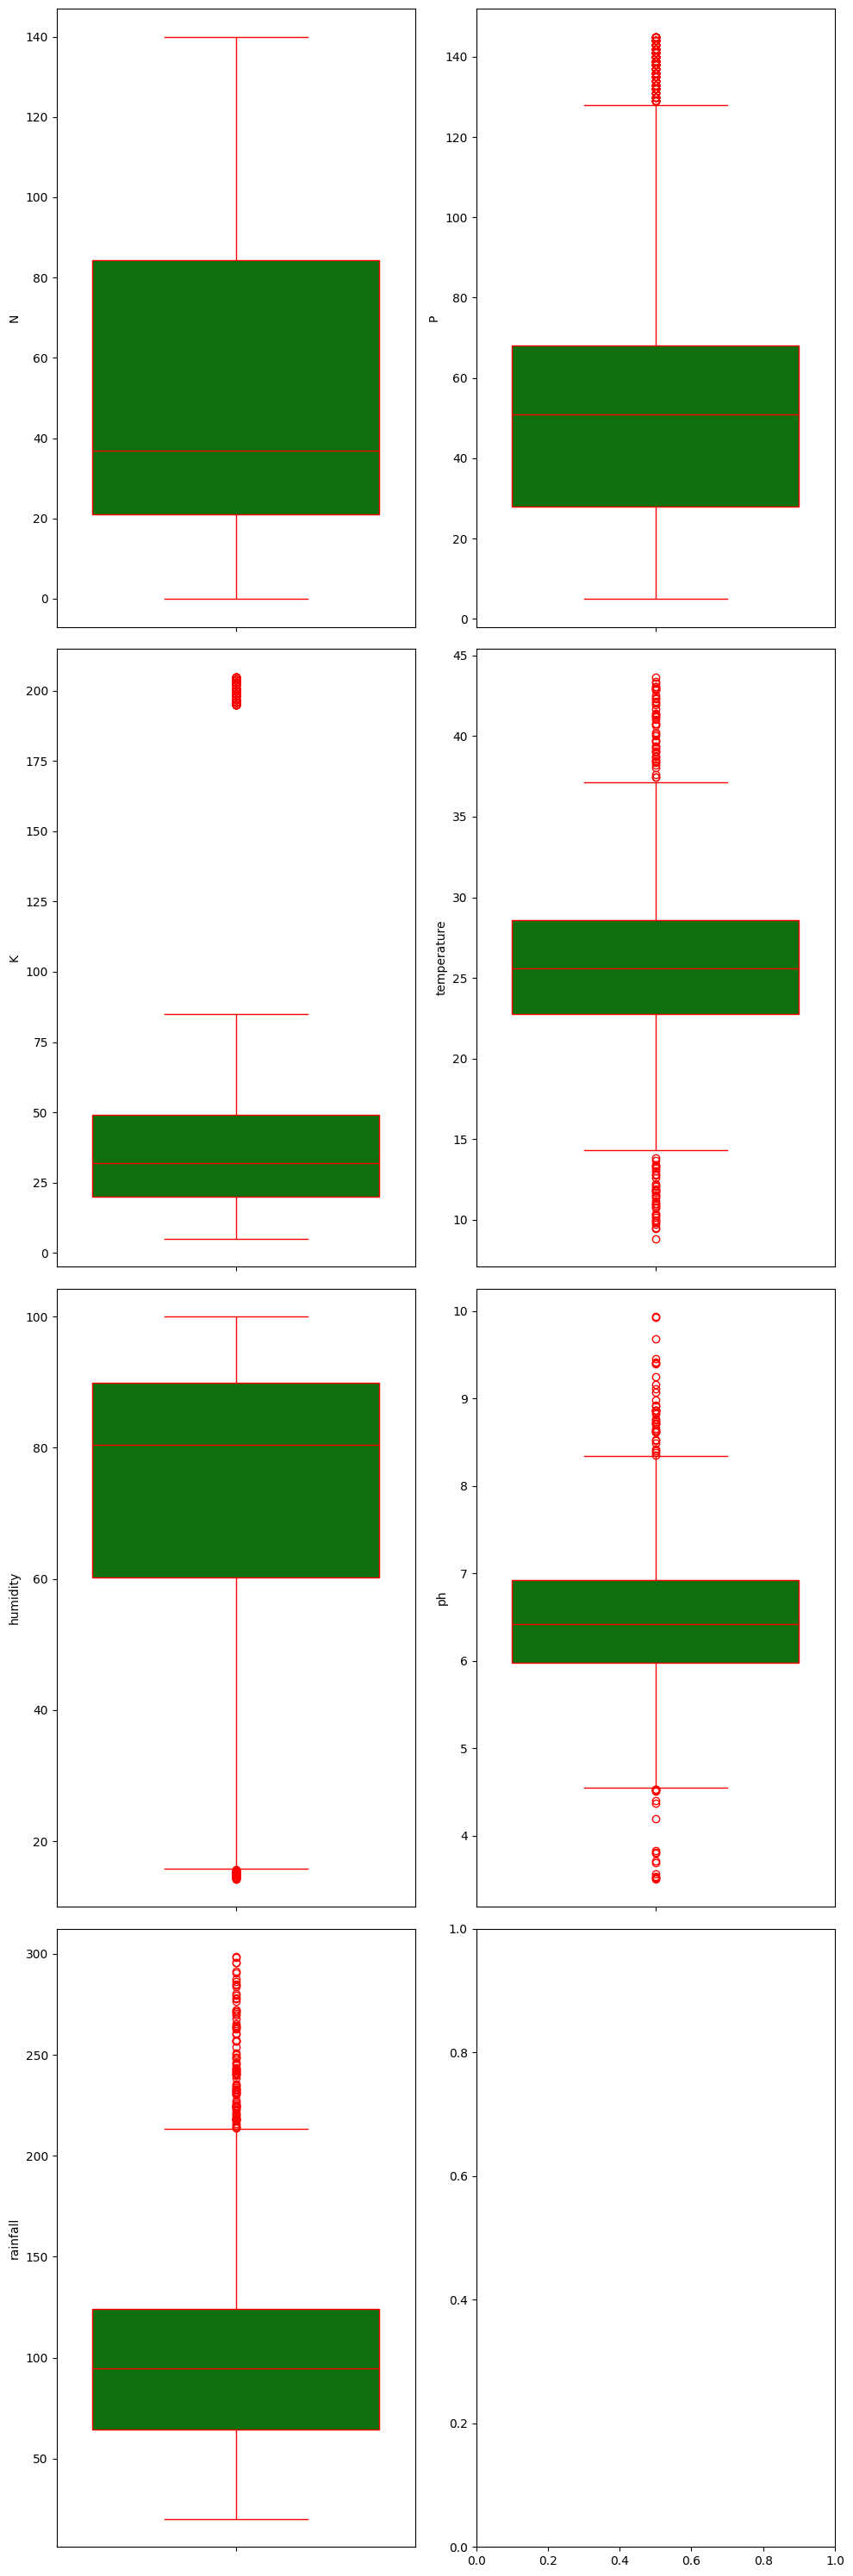

In [15]:
# create box plot for each feature to check for outliers
fig, ax = plt.subplots(4, 2, figsize=(10, 30))
for i, subplot in zip(features, ax.flatten()):
    sns.boxplot(crop_df[i], ax=subplot, color='green', linecolor='red')
plt.tight_layout()
plt.show()


In [16]:
# check the correlation of the features
numeric_columns = crop_df.select_dtypes(include=[np.number])
corr = numeric_columns.corr()
corr

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


In [17]:
import pandas as pd
import plotly.express as px

# If 'corr' is already computed
fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale='Viridis',  # You can use: 'Viridis', 'Cividis', 'Plasma', 'Inferno', etc.
    title="Interactive Heatmap of Features"
)

fig.update_layout(
    width=800,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


In [18]:

crop_dict = {
'rice':1,
'maize':2,
'jute':3,
'cotton':4,
'coconut':5,
'papaya':6,
'orange':7,
'apple':8,
'muskmelon':9,
'watermelon':10,
'grapes':11,
'mango':12,
'banana':13,
'pomegranate':14,
'lentil':15,
'blackgram':16,
'mungbean':17,
'mothbeans':18,
'pigeonpeas':19,
'kidneybeans':20,
'chickpea':21,
'coffee': 22,
}

In [19]:
crop_df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [20]:
crop_df['crop_no'] = crop_df['label'].map(crop_dict)


In [21]:
crop_df.head()


,N,P,K,temperature,humidity,ph,rainfall,label,crop_no
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,1
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,1
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,1
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,1
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,1


In [22]:
crop_df['crop_no'].value_counts()


,count
crop_no,
1,100
2,100
21,100
20,100
19,100
18,100
17,100
16,100
15,100


In [23]:
crop_df.drop('label',axis=1,inplace=True)
crop_df.tail()

,N,P,K,temperature,humidity,ph,rainfall,crop_no
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,22
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,22
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,22
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,22
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,22


#Train Test Spilt


In [24]:

x = crop_df.drop('crop_no',axis=1)
y = crop_df['crop_no']

print(f"The shape of x is : {x.shape}")
print(f"The shape of y is : {y.shape}")

The shape of x is : (2200, 7)
The shape of y is : (2200,)


In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=72)


In [26]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of x_train: (1760, 7)
Shape of y_train: (1760,)
Shape of x_test: (440, 7)
Shape of y_test: (440,)


#SCALING

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)